# Creating Thermal Inertia Map

In [1]:
import sys
import os
print(os.path.abspath('../'))
sys.path.insert(0, os.path.abspath('../'))

import warnings
warnings.filterwarnings('ignore')

from pytes.io import io_db as iodb

from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
import pyspark.sql.functions as funcs

# Math stuff
from math import floor
import numpy as np

# MatPlotLib for colors and basic plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Bokeh + Datashader
import datashader as ds
import datashader.transfer_functions as tf

/home/krodriguez/repos/mgs_tes_data


In [2]:
sqlContext, reader = iodb.spark_from_mongodb(db='tes', collection='point_data')

In [3]:
%%time
df = reader.load()
df = df.filter(df.mars_year == 24).select(["ti_spc", "heliocentric_lon", "loc", "lsubs"]).filter(df.lsubs.between(90,120))
df = df.withColumn("long", df.loc.coordinates[0]).withColumn("lat", df.loc.coordinates[1]).drop("loc")

CPU times: user 12 ms, sys: 8 ms, total: 20 ms
Wall time: 5.18 s


In [4]:
%%time
# Perform the Groupby operation to lump per degree long and lat
df = df.groupby([funcs.floor(df.long), funcs.floor(df.lat)]).agg({"ti_spc": "avg"})

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 47.8 ms


In [5]:
%%time
dfs = df.toPandas()
dfs.head()

CPU times: user 492 ms, sys: 284 ms, total: 776 ms
Wall time: 4min 56s


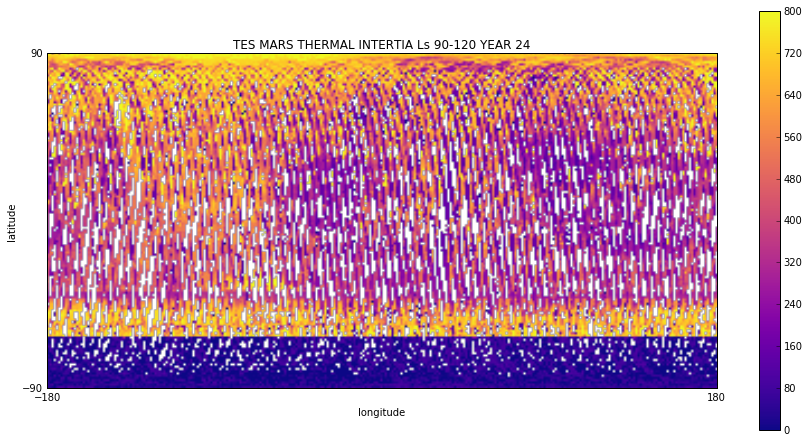

In [6]:
import matplotlib.image as mpimg

def plot_df(df, ls_min=0, ls_max=30, width=300, height=150, year=24):
    cmap = plt.get_cmap('plasma')
    canvas = ds.Canvas(plot_width=width, plot_height=height)

    agg = canvas.points(dfs, 'FLOOR(long)', 'FLOOR(lat)', ds.mean('avg(ti_spc)'))
    img = tf.shade(agg, cmap=cmap)

    plt.figure(figsize=(15,7.5))
    array = np.asarray(img.to_pil())
    plt.imshow(array, cmap='plasma', norm=colors.Normalize(vmin=df['avg(ti_spc)'].min(), vmax=df['avg(ti_spc)'].max()), label="TES Thermal Inertia", extent=[-180,180,-90,90])
    plt.colorbar()
    plt.xlabel("longitude")
    plt.ylabel("latitude")
    plt.xticks([-180,180])
    plt.yticks([-90,90])
    plt.title("TES MARS THERMAL INTERTIA Ls {}-{} YEAR {}".format(ls_min, ls_max, year))
    plt.show()

plot_df(dfs, ls_min=90, ls_max=120, year=24)

## Termal Intertia Kernal Density Estimation

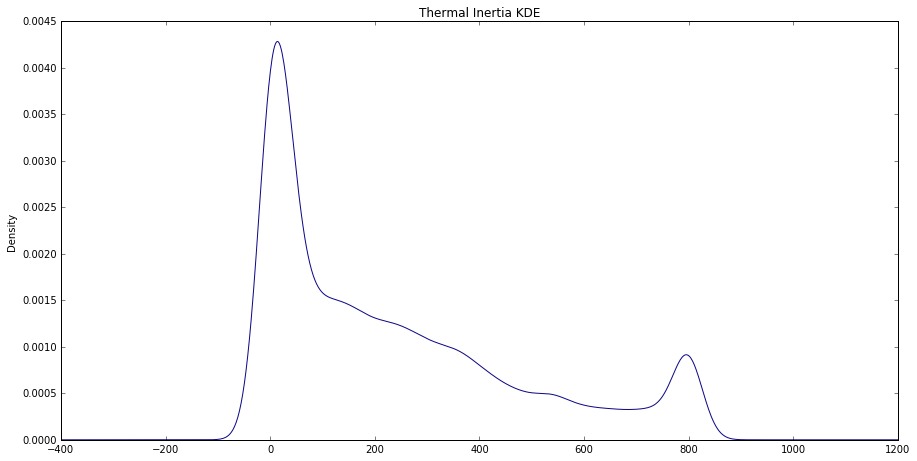

In [7]:
plt.figure(figsize=(15,7.5))
dfs['avg(ti_spc)'].plot.density(colormap='plasma', title='Thermal Inertia KDE')
plt.show()